In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
!pip install minepy
from minepy import MINE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.0/497.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for minepy: filename=minepy-1.2.6-cp310-cp310-linux_x86_64.whl size=187042 sha256=bf2dacbd20121a7f06cc809d9a7801582d65f16aa748382fe1211e370666d366
  Stored in directory: /root/.cache/pip/wheels/69/38/a6/825bb9b9ed81e6af43a0ef80c7cfe4cafcfdbc2f5cde2959d9
Successfully built minepy


In [2]:
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
import altair as alt
from IPython.display import display

Mounted at /content/gdrive


# Data Load and preprocessing

In [3]:
df = pd.read_csv('train_all_inner.csv', index_col = 0)
print(df.shape)
df.head()

(144233, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
# NULL Value Table
def create_summary_table(df):
  summary = pd.DataFrame(index = df.columns)
  summary['Data Type'] = df.dtypes.values
  summary['# Nonnull records'] = df.count().values
  summary['# Non-zero records'] = df.astype(bool).sum(axis=0)
  summary['% null records'] = round(df.isna().sum()/df.shape[0]*100,2)
  summary['% non-zero records'] = round(df.astype(bool).sum(axis=0) / df.shape[0]*100,2)
  summary['Unique values'] = df.nunique().values
  summary.to_csv('summary_table.csv')
  return summary

In [5]:
summary = create_summary_table(df)
summary

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
TransactionID,int64,144233,144233,0.00,100.00,144233
isFraud,int64,144233,11318,0.00,7.85,2
TransactionDT,int64,144233,144233,0.00,100.00,142734
TransactionAmt,float64,144233,144233,0.00,100.00,7830
ProductCD,object,144233,144233,0.00,100.00,4
...,...,...,...,...,...,...
id_36,object,140985,144233,2.25,100.00,2
id_37,object,140985,144233,2.25,100.00,2
id_38,object,140985,144233,2.25,100.00,2
DeviceType,object,140810,144233,2.37,100.00,2


In [6]:
summary.to_csv('summary_table.csv')

### Split categorical and numerical features

In [7]:
full_data_col = df.loc[:, df.isnull().sum() == 0].columns.values
feature_col = df.columns[df.dtypes == 'object']
numerical_col = df.columns[df.dtypes != 'object']
feature_col_NAN = [col for col in feature_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
num_full_col = [col for col in numerical_col if col in full_data_col]

### Calculate corr and mic

In [60]:
# we would like to calculate the correlation of all numerical columns with the target column
corr_map = {}
target_col = df['isFraud']
for col in numerical_col_NAN:
    new = df.filter(['isFraud',col], axis=1)
    new = new.dropna(how='any')
    corr= df['isFraud'].corr(df[col])
    corr_map[col] = corr
    # print('feature: ', col)
    # print('Pearsons correlation: %.3f' % corr)

In [63]:
top_10_abs_values = sorted(corr_map.items(), key=lambda item: abs(item[1]), reverse=True)[:10]
print("Top 10 absolute correlation values and their keys:")
for key, value in top_10_abs_values:
  print(f"Key: {key}, Value: {value}")
# the results show that there is no numerical values have high correlationship with target column('isFraud')

Top 10 absolute correlation values and their keys:
Key: V258, Value: 0.3010423200462532
Key: V228, Value: 0.2689698502443172
Key: V170, Value: 0.24979447724564646
Key: V230, Value: 0.23441121278537855
Key: V171, Value: 0.2165084943537856
Key: V222, Value: 0.16628076702992545
Key: V259, Value: 0.1515666650990784
Key: V262, Value: 0.15139448716322657
Key: id_17, Value: 0.1501004599249427
Key: card3, Value: 0.14845948588273858


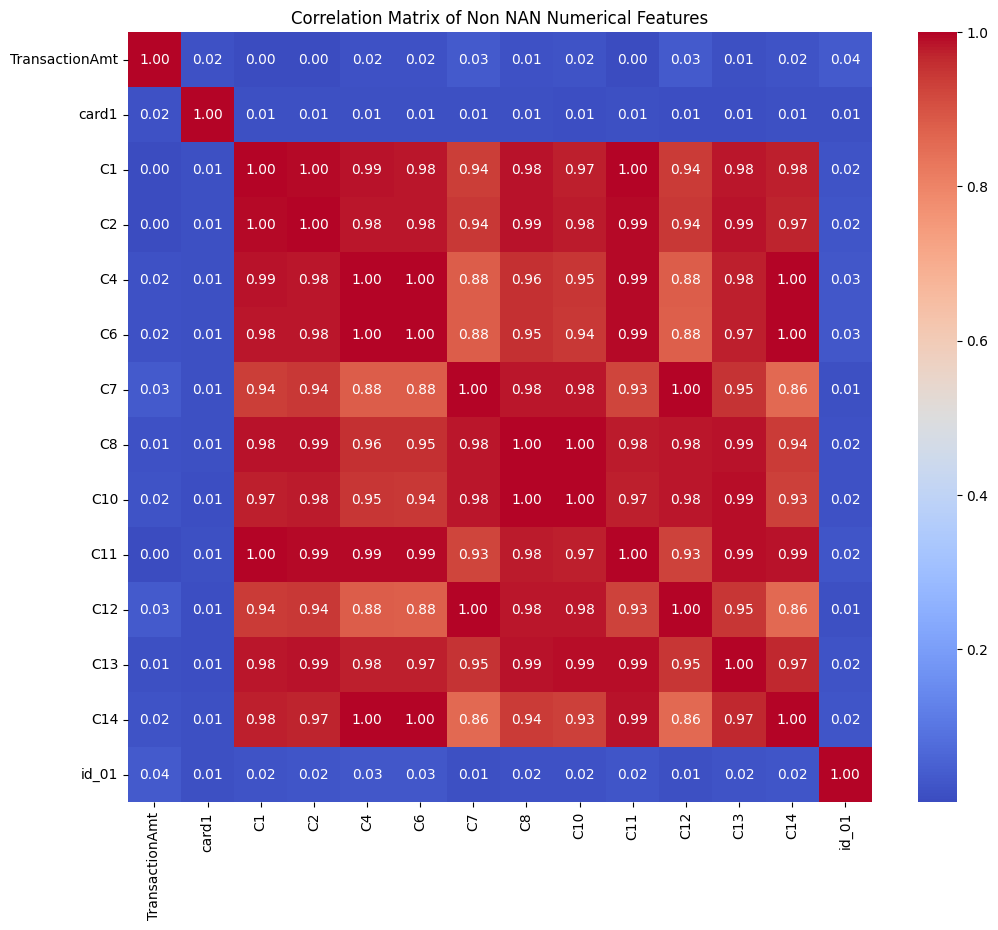

In [59]:
# the we would like to see the correlationship among non nan numerical features
df_corr = df[num_full_col[3:]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Non NAN Numerical Features')
plt.show()

In [64]:
non_nan_num_col = ['TransactionAmt','card1','C1','id_01']


In [9]:
'''# 在之后计算的时候，需要把target换成所有non unique value 的特征
# mine.compute_score(x, y)
mine = MINE(alpha=0.6)
mic_map = {}
target_col = df['isFraud']
for col in numerical_col_NAN:
    mine.compute_score(target_col, df[col])
    mic_map[col] = mine.mic()'''

"# 在之后计算的时候，需要把target换成所有non unique value 的特征\n# mine.compute_score(x, y)\nmine = MINE(alpha=0.6)\nmic_map = {}\ntarget_col = df['isFraud']\nfor col in numerical_col_NAN:\n    mine.compute_score(target_col, df[col])\n    mic_map[col] = mine.mic()"

### Drop data by NAN% and dominate %

In [10]:
def threshold(t_null, t_dominant, df):
    many_null_col = list(set(
        [col for col in df.columns if df[col].isnull().mean() > t_null]))

    dominant_value_col =list(set(
        [col for col in df.columns
            if df[col].value_counts(dropna=False, normalize=True).values[0] > t_dominant]))
    cols_to_drop = list(set(many_null_col+
        dominant_value_col))
    return cols_to_drop

In [11]:
cols_to_drop=threshold(0.2, 0.8, df)
cols_to_drop.remove('isFraud')
df_drop = df.drop(columns=cols_to_drop)

print(df_drop.shape)
df_drop.head()

(144233, 83)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_19,id_20,id_28,id_29,id_31,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,542.0,144.0,New,NotFound,samsung browser 6.2,T,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,410.0,142.0,Found,Found,chrome 62.0,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,176.0,507.0,New,NotFound,chrome 62.0,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,529.0,575.0,Found,Found,chrome 62.0,T,T,T,desktop,MacOS


In [12]:
full_data_col = df_drop.loc[:, df_drop.isnull().sum() == 0].columns.values
categorical_col = df_drop.columns[df_drop.dtypes == 'object']
numerical_col = df_drop.columns[df_drop.dtypes != 'object']
categorical_col_NAN = [col for col in categorical_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
num_full_col = [col for col in numerical_col if col in full_data_col]
categorical_full_col = [col for col in categorical_col if col in full_data_col]

In [13]:
df_drop_summary = create_summary_table(df_drop)
df_drop_summary.to_csv('df_drop_summary.csv')

### correlation among numerical_col_nan and numerical_full_col

In [68]:
non_nan_num_col = ['TransactionAmt','card1','C1','id_01']
corr_check ={}
for nan_col in numerical_col_NAN:
    corr_check[nan_col]={}
    for full_col in non_nan_num_col:
        correlation = df_drop[nan_col].corr(df_drop[full_col])
        corr_check[nan_col][full_col] = correlation
avg_corr, max_feature, max_corr = [],[],[]
for i in corr_check.values():
    each_corr_value = list(i.values())
    each_corr_feature = list(i.keys())
    avg_corr.append(sum(each_corr_value)/len(each_corr_value))
    abs_corr = list(map(lambda x: abs(x), each_corr_value))
    max_abs_index = abs_corr.index(max(abs_corr))
    max_feature.append(each_corr_feature[max_abs_index])
    max_corr.append(each_corr_value[max_abs_index])

In [69]:
df_corr_check = pd.DataFrame(list(zip(*[numerical_col_NAN, avg_corr, max_feature, max_corr])),
                             columns=['Nan_Feature', 'Avg_Corr', 'Max_NotNull_Feature', 'Max_Corr_Abs']).sort_values(by='Max_Corr_Abs')
df_corr_check = df_corr_check.reindex(df_corr_check['Max_Corr_Abs'].abs().sort_values(ascending=False).index)
df_corr_check.head()

,Nan_Feature,Avg_Corr,Max_NotNull_Feature,Max_Corr_Abs
48,id_17,-0.109185,TransactionAmt,-0.334971
1,card3,-0.071577,TransactionAmt,-0.256826
46,id_06,0.055615,id_01,0.201637
2,card5,-0.042325,card1,-0.199373
32,V263,0.045591,TransactionAmt,0.156411


#### Deal with Categorical Features

1. KNN：card6, id_16,id_28,id_29,id_35,id_37,id_38,card4, Device Type
3. Simply Fill, id_15->Unknow
4. Need preprocess: P_emaildomain, R_emaildomain,id_31 and Device info

In [14]:
categorical_col_NAN

['card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

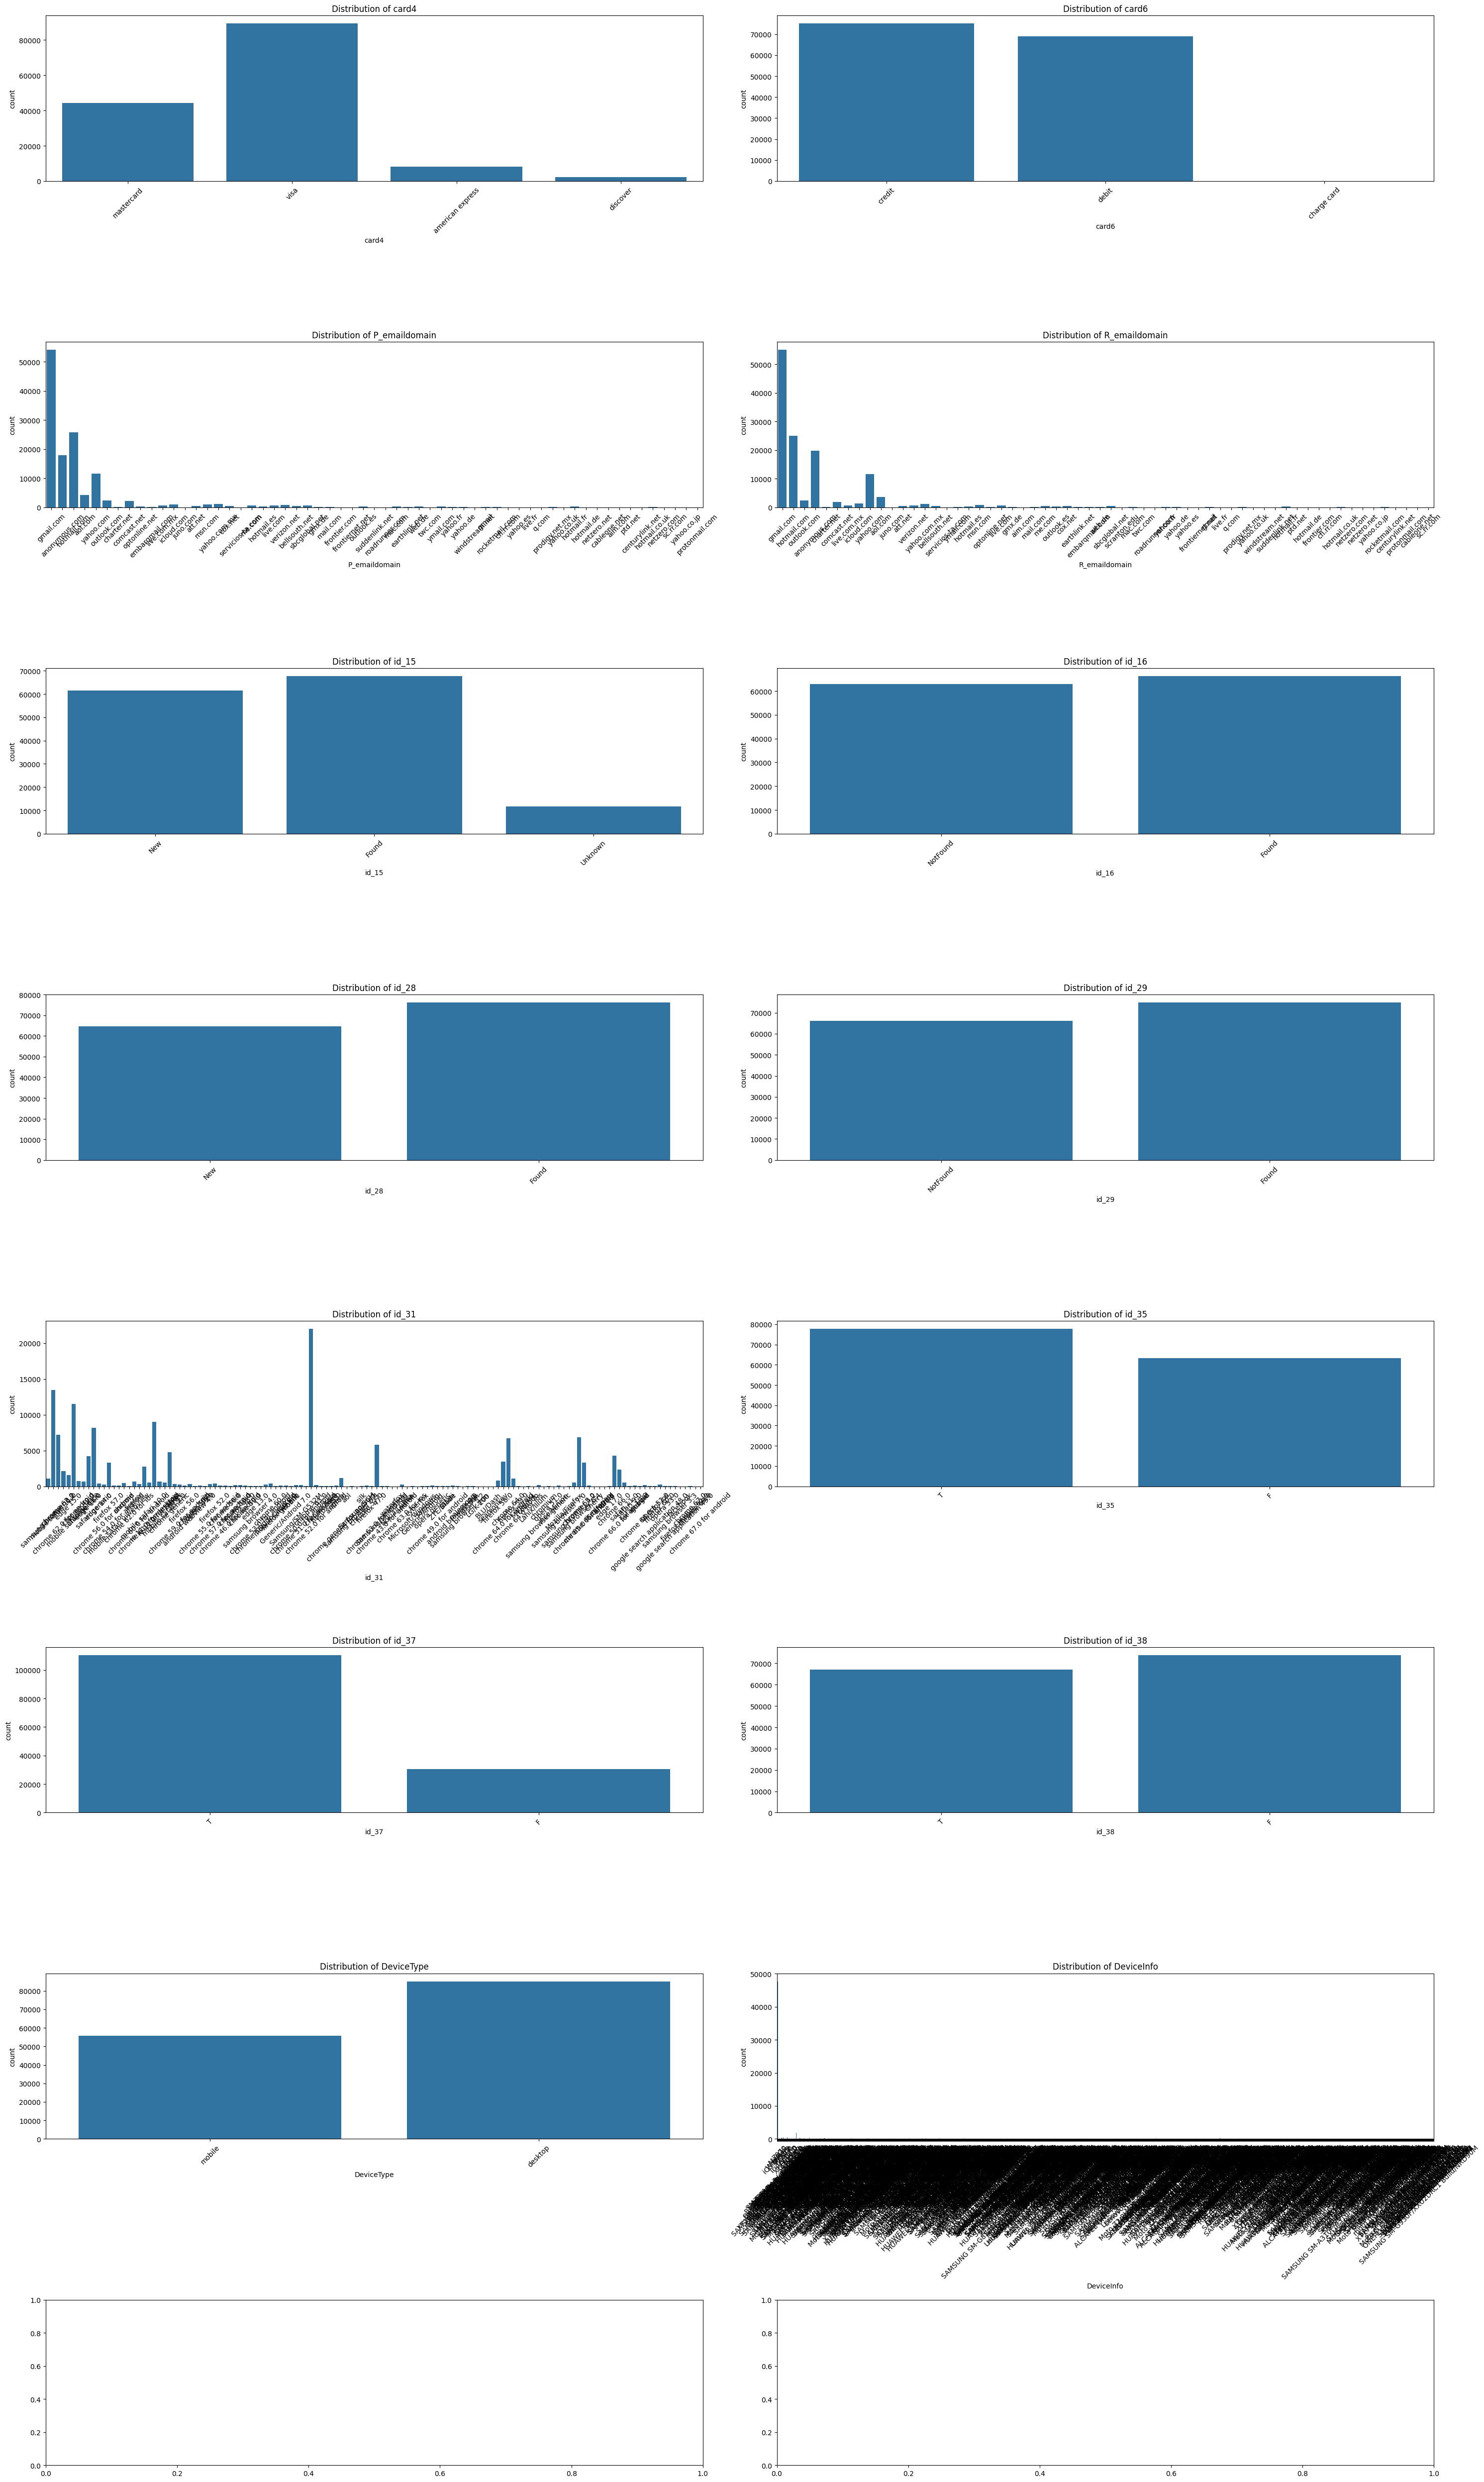

In [15]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(30, 50))
axes = axes.flatten()

# Plot the distribution of each categorical feature
for i, col in enumerate(categorical_col_NAN):
    sns.countplot(data=df_drop, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

##### KNN filling

In [16]:
def fill_na_knn_classifier(df, feature_with_nan, non_nan_features):
    missing_mask = df[feature_with_nan].isna()
    X_train = df.loc[~missing_mask, non_nan_features]
    y_train = df.loc[~missing_mask, feature_with_nan]
    X_test = df.loc[missing_mask, non_nan_features]
    '''print('X_train shape', X_train.shape)
    print('y_train shape', y_train.shape)
    print('X_test shape', X_test.shape)'''
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    # print('finish model train')
    # print('shape of missing', df.loc[missing_mask, feature_with_nan])
    y_pred = knn.predict(X_test)
    # print('shape of prediction', df.loc[missing_mask, feature_with_nan])
    df.loc[missing_mask, feature_with_nan] = y_pred
    return df


In [17]:
num_full_col[3:]

['TransactionAmt',
 'card1',
 'C1',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'id_01']

In [18]:
knn_filling_freatures = ['card6', 'id_16', 'id_28', 'id_29', 'id_35', 'id_37', 'id_38', 'card4','DeviceType']
new_df = df_drop.copy()
for col in knn_filling_freatures:
    # print('col shape', )
    new_df = fill_na_knn_classifier(new_df, col,num_full_col[3:])

In [19]:
new_df_summary = create_summary_table(new_df)
new_df_summary.loc[knn_filling_freatures]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
card6,object,144233,144233,0.0,100.0,3
id_16,object,144233,144233,0.0,100.0,2
id_28,object,144233,144233,0.0,100.0,2
id_29,object,144233,144233,0.0,100.0,2
id_35,object,144233,144233,0.0,100.0,2
id_37,object,144233,144233,0.0,100.0,2
id_38,object,144233,144233,0.0,100.0,2
card4,object,144233,144233,0.0,100.0,4
DeviceType,object,144233,144233,0.0,100.0,2


##### Simple filling

In [20]:
new_df['id_15'].unique()

array(['New', 'Found', nan, 'Unknown'], dtype=object)

In [21]:
new_df['id_15'] = new_df['id_15'].fillna('Unknown')

##### Preprocessing categorical data/ Detect categorical outliers

###### Email Domain Preprocessing

In [22]:
categorical_col_NAN

['card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [23]:
new_df['P_emaildomain'].unique()

array(['gmail.com', 'anonymous.com', 'hotmail.com', 'aol.com',
       'yahoo.com', nan, 'outlook.com', 'charter.net', 'comcast.net',
       'optonline.net', 'embarqmail.com', 'live.com.mx', 'icloud.com',
       'juno.com', 'att.net', 'msn.com', 'yahoo.com.mx', 'cox.net',
       'servicios-ta.com', 'me.com', 'hotmail.es', 'live.com',
       'verizon.net', 'bellsouth.net', 'sbcglobal.net', 'gmx.de',
       'mail.com', 'frontier.com', 'frontiernet.net', 'outlook.es',
       'suddenlink.net', 'roadrunner.com', 'mac.com', 'earthlink.net',
       'web.de', 'twc.com', 'ymail.com', 'yahoo.fr', 'yahoo.de',
       'windstream.net', 'gmail', 'rocketmail.com', 'cfl.rr.com',
       'yahoo.es', 'live.fr', 'q.com', 'prodigy.net.mx', 'yahoo.co.uk',
       'hotmail.fr', 'hotmail.de', 'netzero.net', 'cableone.net',
       'aim.com', 'ptd.net', 'centurylink.net', 'hotmail.co.uk',
       'netzero.com', 'sc.rr.com', 'yahoo.co.jp', 'protonmail.com'],
      dtype=object)

In [24]:
p_emaildomain_counts = df_drop['P_emaildomain'].value_counts(normalize=True)*100
email_counts = {}
for i in p_emaildomain_counts.values:
    email_counts[i//1] = email_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in email_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_emailcount = pd.DataFrame({'email %':l_keys, 'Count':l_values})
df_emailcount.sort_values(by='email %',ascending=False)

,email %,Count
0,41.0,1
1,19.0,1
2,13.0,1
3,8.0,1
4,3.0,1
5,1.0,2
6,0.0,52


In [25]:
threshold = 1
# print(p_emaildomain_counts)
p_emaildomain_others = p_emaildomain_counts[p_emaildomain_counts < threshold].index.tolist()
new_df['P_emaildomain'] = df_drop['P_emaildomain'].apply(lambda x: 'others' if x in p_emaildomain_others else x)

In [26]:
r_emaildomain_counts = df_drop['R_emaildomain'].value_counts(normalize=True)*100
email_counts = {}
for i in r_emaildomain_counts.values:
    email_counts[i//1] = email_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in email_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_emailcount = pd.DataFrame({'email %':l_keys, 'Count':l_values})
df_emailcount.sort_values(by='email %',ascending=False)

,email %,Count
0,42.0,1
1,19.0,1
2,15.0,1
3,8.0,1
4,2.0,1
5,1.0,3
6,0.0,52


In [27]:
threshold = 1
r_emaildomain_others = r_emaildomain_counts[r_emaildomain_counts < threshold].index.tolist()
new_df['R_emaildomain'] = df_drop['R_emaildomain'].apply(lambda x: 'others' if x in r_emaildomain_others else x)

In [28]:
knn_filling_freatures = ['R_emaildomain','P_emaildomain']
for col in knn_filling_freatures:
    new_df = fill_na_knn_classifier(new_df, col,num_full_col[3:])

In [29]:
new_df_summary = create_summary_table(new_df)
new_df_summary.loc[knn_filling_freatures]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
R_emaildomain,object,144233,144233,0.0,100.0,9
P_emaildomain,object,144233,144233,0.0,100.0,8


###### Device Info Preprocessing

In [30]:
unique_device_info = new_df['DeviceInfo'].unique()
with open('unique_device_info.txt', 'w') as f:
  for device in unique_device_info:
    f.write(str(device) + '\n')

In [31]:
new_df.to_csv('Dataset_with_filling_nan_categorical.csv')

###### id_31 Browser Type Preprocessing

In [32]:
unique_browser_info = new_df['id_31'].unique()
unique_browser_info

array(['samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0', nan,
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [33]:
browser_type = [
    'chrome','safari','firefox','edge','other', 'samsung','opera','silk','waterfox','Nokia','puffin','Microsoft','cyberfox','ZTE','palemoon','maxthon','line','LG',
    'konqueror','iceweasel','iron','BLU','seamonkey','M4','comodo','Lanix','Inco','Cherry','icedragon','BLU','android'
]

In [34]:
unique_browser_info

array(['samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0', nan,
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [35]:
transfer_map = {}
for browser in unique_browser_info:
    browser_lower = str(browser).lower()
    for keyword in browser_type:
        keyword_lower = keyword.lower()
        if keyword_lower in browser_lower:
            transfer_map[browser] = keyword
            break
        elif 'google' in browser_lower or 'chromium' in browser_lower:
          transfer_map[browser] = 'chrome'
        elif 'ie' in browser_lower:
          transfer_map[browser] = 'edge'
        else:
          transfer_map[browser] = browser

In [36]:
df_drop['id_31'] = df_drop['id_31'].map(transfer_map)
df['id_31'] = df['id_31'].map(transfer_map)

In [37]:
new_df['id_31'] = new_df['id_31'].map(transfer_map)

browser_type_counts = df_drop['id_31'].value_counts(normalize=True)*100
browser_counts = {}
for i in browser_type_counts.values:
    browser_counts[i//1] = browser_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in browser_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_browser_type = pd.DataFrame({'browser_type %':l_keys, 'Count':l_values})
df_browser_type.sort_values(by='browser_type %',ascending=False)

,browser_type %,Count
0,54.0,1
1,26.0,1
2,11.0,1
3,5.0,1
4,1.0,1
5,0.0,26


In [38]:
threshold = 1
browser_type_others = browser_type_counts[browser_type_counts < threshold].index.tolist()
new_df['id_31'] = df_drop['id_31'].apply(lambda x: 'others' if x in browser_type_others else x)
new_df = fill_na_knn_classifier(new_df, 'id_31',num_full_col[3:])

In [39]:
new_df['id_31'].value_counts(normalize=True)*100

,proportion
id_31,
chrome,54.506250
safari,26.353886
edge,11.675553
firefox,4.913577
samsung,1.575922
others,0.974812


In [40]:
new_df_summary = create_summary_table(new_df)
new_df_summary.loc[categorical_col_NAN]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
card4,object,144233,144233,0.00,100.0,4
card6,object,144233,144233,0.00,100.0,3
P_emaildomain,object,144233,144233,0.00,100.0,8
R_emaildomain,object,144233,144233,0.00,100.0,9
id_15,object,144233,144233,0.00,100.0,3
id_16,object,144233,144233,0.00,100.0,2
id_28,object,144233,144233,0.00,100.0,2
id_29,object,144233,144233,0.00,100.0,2
id_31,object,144233,144233,0.00,100.0,6
id_35,object,144233,144233,0.00,100.0,2


#### Deal with Numerical feature

In [41]:
def fill_na_knn_regressor(df, feature_with_nan, non_nan_features):
    missing_mask = df[feature_with_nan].isna()
    X_train = df.loc[~missing_mask, non_nan_features]
    y_train = df.loc[~missing_mask, feature_with_nan]
    X_test = df.loc[missing_mask, non_nan_features]
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    df.loc[missing_mask, feature_with_nan] = knn.predict(X_test)
    return df
for feature in numerical_col_NAN:
    if df[feature].isna().sum() > 0:
        new_df2 = fill_na_knn_regressor(new_df, feature, num_full_col[3:])


In [42]:
new_df2_summary = create_summary_table(new_df2)
new_df2_summary.loc[numerical_col_NAN]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
card2,float64,144233,144233,0.0,100.00,612
card3,float64,144233,144233,0.0,100.00,116
card5,float64,144233,144233,0.0,100.00,187
D1,float64,144233,29670,0.0,20.57,666
V167,float64,144233,35432,0.0,24.57,894
V168,float64,144233,40134,0.0,27.83,1004
V170,float64,144233,134459,0.0,93.22,70
V171,float64,144233,134573,0.0,93.30,84
V202,float64,144233,35432,0.0,24.57,11825
V203,float64,144233,43719,0.0,30.31,16022


In [43]:
new_df2.to_csv('Dataset_with_filling_nan_numerical.csv')

## Outerlier detection

#### IQR detects outliers

In [44]:
def find_outlier_indices(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    return outlier_indices


In [45]:
def draw_outlier_boxplot(df, feature):
    fig, ax = plt.subplots(figsize=(6, 20))
    ax.boxplot(x=df[feature])
    ax.set_title(f'Box Plot of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Value')
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    outliers = df.loc[outlier_indices, feature]
    # ax.scatter(outliers.index, outliers, color='red', label='Outliers')
    ax.legend()
    plt.show()


In [46]:
outliers_map = {}
for col in numerical_col_NAN:
    outliers = find_outlier_indices(new_df2, col)
    outliers_map[col] = outliers
    # print(f'Number of outliers in {col}: {len(outliers)}')

In [47]:
new_df2.shape[0]

144233

In [48]:
for k,v in outliers_map.items():
    if v.shape[0] > 0:
        print(f'Number of outliers in {k}: {len(v)/144233}')
        # draw_outlier_boxplot(new_df2, k)

Number of outliers in D1: 0.20570881837027588
Number of outliers in V167: 0.245658067155228
Number of outliers in V168: 0.09868060707327726
Number of outliers in V170: 0.27971407375565926
Number of outliers in V171: 0.31329168775522936
Number of outliers in V202: 0.245658067155228
Number of outliers in V203: 0.1815326589615414
Number of outliers in V204: 0.1913223742139455
Number of outliers in V217: 0.08180513474724924
Number of outliers in V218: 0.11892562728363135
Number of outliers in V219: 0.09908966741314401
Number of outliers in V221: 0.42098548875777386
Number of outliers in V222: 0.43781936172720526
Number of outliers in V224: 0.16207109330042363
Number of outliers in V228: 0.17156267983055196
Number of outliers in V229: 0.23026630521447936
Number of outliers in V230: 0.1980961361130948
Number of outliers in V231: 0.15262803935299135
Number of outliers in V232: 0.1725402647105725
Number of outliers in V233: 0.1621820249180146
Number of outliers in V245: 0.27816796433548496
Num

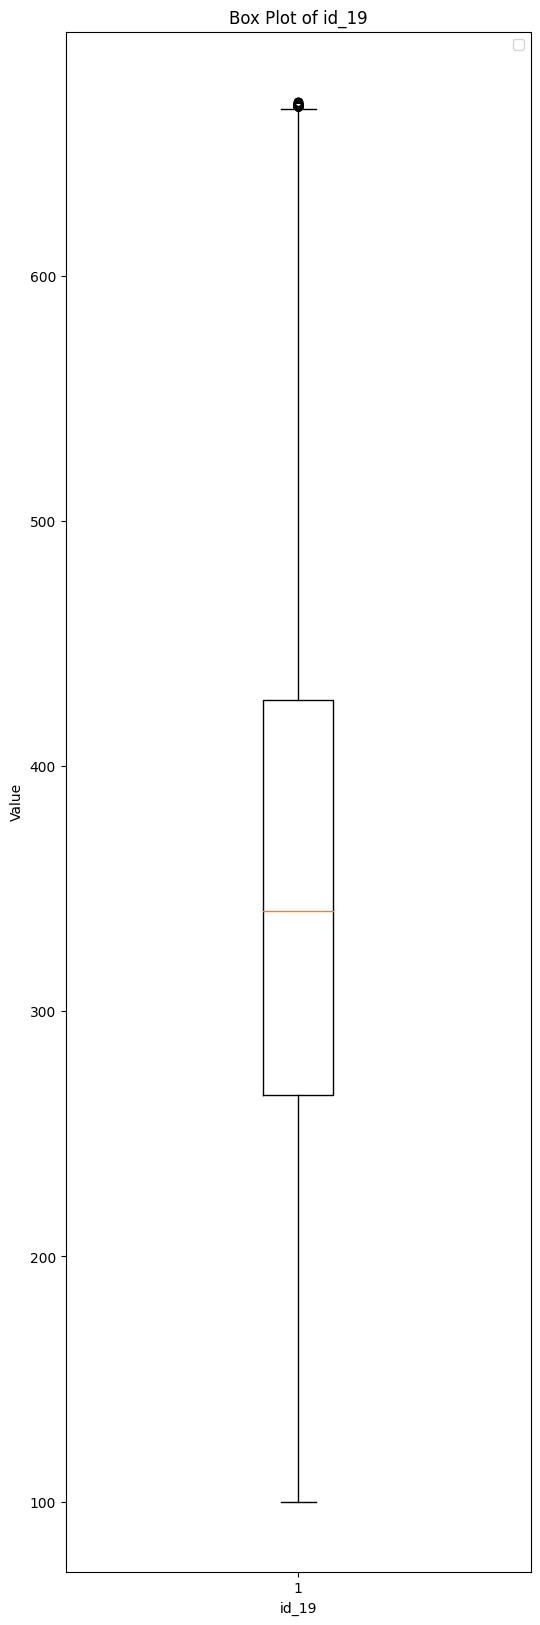

In [49]:
draw_outlier_boxplot(new_df2, 'id_19')

#### Isolation Forest detects outliers

In [51]:
temp_df2 = new_df2.copy()
temp_df2 = temp_df2.drop('isFraud',axis=1)
numerical_features = temp_df2.select_dtypes(include=np.number).columns
model = IsolationForest(contamination='auto', random_state=42)
model.fit(temp_df2[numerical_features])
outlier_predictions = model.predict(temp_df2[numerical_features])
temp_df2['outlier_prediction'] = outlier_predictions
outliers = temp_df2[temp_df2['outlier_prediction'] == -1]
print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 7131


In [52]:
temp_df2['TransactionID'][temp_df2['outlier_prediction'] == 1]

,TransactionID
0,2987004
1,2987008
2,2987010
3,2987011
4,2987016
...,...
144227,3577509
144229,3577526
144230,3577529
144231,3577531


In [53]:
new_df2['TransactionID'][new_df2['isFraud'] == 1]

,TransactionID
52,2987240
53,2987243
54,2987245
69,2987288
86,2987367
...,...
144202,3577351
144203,3577354
144204,3577364
144206,3577368


In [65]:
transaction_id_outliers = temp_df2['TransactionID'][temp_df2['outlier_prediction'] == -1]
transaction_id_fraud = new_df2['TransactionID'][new_df2['isFraud'] == 1]
common_transaction_ids = len(set(transaction_id_outliers) & set(transaction_id_fraud))
print(f"Number of transaction IDs that are both fraud and outliers: {common_transaction_ids/len(transaction_id_fraud)}")

Number of transaction IDs that are both fraud and outliers: 0.18077398833716204


# Model Training

## Train/Test Split, Normalization, PCA

In [70]:

X = new_df2.sort_values('TransactionDT').drop((['isFraud', 'TransactionDT', 'TransactionID']+list(categorical_col)), axis=1)
y = list(new_df2.sort_values('TransactionDT')['isFraud'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)

In [77]:
pca = PCA(n_components=2)
pca.fit(X_scaled_train)
X_pca_train = pca.transform(X_scaled_train)
X_pca_test = pca.transform(X_scaled_test)

## Isolation Forest

In [78]:
IF = IsolationForest(n_estimators=200, contamination=0.08, n_jobs=-1, random_state=42).fit(X_train)
df_IF = pd.DataFrame(IF.decision_function(X_test), columns = ['Anomaly score'])
df_IF['predict'] = IF.predict(X_test)
df_IF['isFraud'] = y_test
df_IF

,Anomaly score,predict,isFraud
0,0.125166,1,0
1,-0.323472,-1,0
2,0.127000,1,0
3,0.136237,1,0
4,0.090499,1,0
...,...,...,...
28842,0.125962,1,0
28843,0.122351,1,0
28844,0.129185,1,0
28845,0.135947,1,0


In [79]:
print(df_IF[df_IF['predict']==1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF[df_IF['predict']==-1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF['predict'].value_counts(dropna=False, normalize = True))

isFraud
0    0.942996
1    0.057004
Name: proportion, dtype: float64
isFraud
0    0.682947
1    0.317053
Name: proportion, dtype: float64
predict
 1    0.917669
-1    0.082331
Name: proportion, dtype: float64


In [80]:
IF = IsolationForest(n_estimators=200, contamination=0.08, n_jobs=-1, random_state=42).fit(X_pca_train)
df_IF = pd.DataFrame(IF.decision_function(X_pca_test), columns = ['Anomaly score'])
df_IF['predict'] = IF.predict(X_pca_test)
df_IF['isFraud'] = y_test
df_IF

,Anomaly score,predict,isFraud
0,0.105110,1,0
1,-0.388299,-1,0
2,0.103097,1,0
3,0.103121,1,0
4,0.000297,1,0
...,...,...,...
28842,0.097437,1,0
28843,0.094478,1,0
28844,0.099286,1,0
28845,0.095042,1,0


In [81]:
print(df_IF[df_IF['predict']==1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF[df_IF['predict']==-1]['isFraud'].value_counts(dropna=False, normalize = True))
print(df_IF['predict'].value_counts(dropna=False, normalize = True))

isFraud
0    0.942174
1    0.057826
Name: proportion, dtype: float64
isFraud
0    0.686072
1    0.313928
Name: proportion, dtype: float64
predict
 1    0.91961
-1    0.08039
Name: proportion, dtype: float64


## One class SVM

In [ ]:
OC_SVM = svm.OneClassSVM().fit(X_scaled_train)
df_OC_SVM = pd.DataFrame(
    OC_SVM.score_samples(
df_test[df_test['isFraud']==1].drop((['isFraud', 'TransactionDT', 'TransactionID']
                    +list(categorical_col)), axis=1),
    columns = ['Anomaly score']))
df_OC_SVM['predict'] = df_OC_SVM.predict(X_test)
df_IF['isFraud'] = y_test

In [ ]:
X = df_test.sort_values('TransactionDT').drop((['isFraud', 'TransactionDT', 'TransactionID']+list(categorical_col)), axis=1)
y = list(df_test.sort_values('TransactionDT')['isFraud'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_IF.sort_values(by='Anomaly score', ascending=True)

In [ ]:
df_IF[df_IF['isFraud']==1]['predict'].value_counts(dropna=False, normalize = True)

In [ ]:
df_test['isFraud'].mean()